In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np

# Read in the data
df = pd.read_csv('week05/nwo_grants.csv', sep=';')

1. Exercise 1. DAG and estimate total causal effect

Gender, Discipline, Award

G -> D
D -> A
G -> A

In [13]:
df["award_rate"] = df["awards"] / df["applications"]
df["gender_int"] = (df["gender"] == 'm').astype(int)

with pm.Model() as binomial_regression_model:
    gender = pm.Normal("g", mu=0, sigma=1, shape=2)
    # linear model
    mu = gender[df["gender_int"].values]
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Binomial("y", n=df["applications"].values, p=p, observed=df["awards"].values)


# # Use regression approach
# with pm.Model() as binomial_regression_model:
#     # priors
#     b0 = pm.Normal("b0", mu=0, sigma=1)
#     b1 = pm.Normal("b1", mu=0, sigma=1)
#     # linear model
#     mu = b0 + b1 * df["gender_int"].values
#     p = pm.Deterministic("p", pm.math.invlogit(mu))
#     # likelihood
#     pm.Binomial("y", n=df["applications"].values, p=p, observed=df["awards"].values)

In [3]:
# pm.model_to_graphviz(binomial_regression_model)

In [14]:
with binomial_regression_model:
    trace = pm.sample(1000, tune=1000, cores=2)

/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b1, b0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.


/var/folders/ff/3y2196b13bq0nbm3_ms25nyh0000gp/T/ipykernel_6392/2487064176.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, figsize=(12, 12))


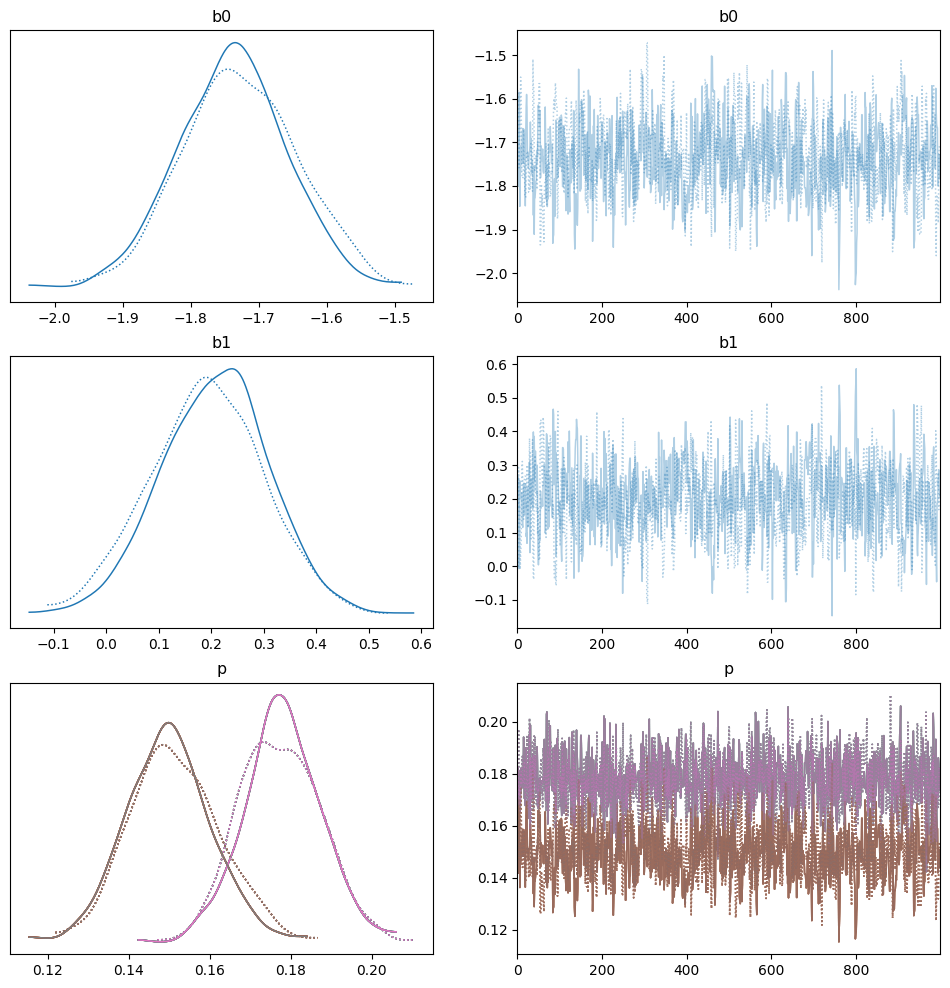

In [15]:
with binomial_regression_model:
    pm.traceplot(trace, figsize=(12, 12))

In [6]:
with binomial_regression_model:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["p"], random_seed=43, samples=10_000
    )

In [10]:
men = ppc["p"].T[df["gender_int"].values == 1]
women = ppc["p"].T[df["gender_int"].values == 0]
print("ATE", (men - women)[0].mean())

ATE 0.02808790160021615


<Axes: ylabel='Density'>

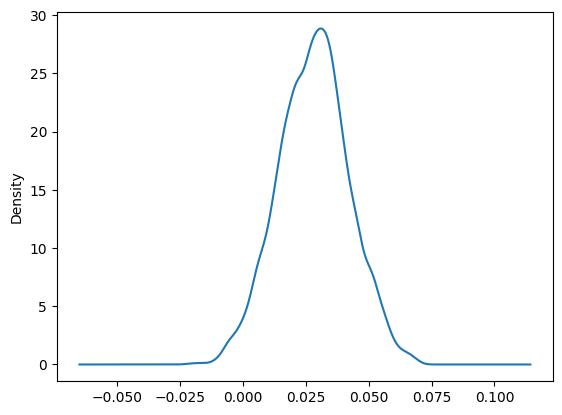

In [11]:
pd.Series((men - women)[0]).plot.kde()

In [12]:
# Frequentist approach
df.groupby("gender").agg({"applications": "sum", "awards": "sum", "award_rate": "mean"}).assign(
    award_rate_real=lambda x: x["awards"] / x["applications"]
)

,applications,awards,award_rate,award_rate_real
gender,,,,
f,1188,177,0.188790,0.14899
m,1635,290,0.191899,0.17737


2. Now estimate direct effect. Should we use one or more binomial models?
Direct effect should be weighted accross the number of applications.


This is not right :(

In [19]:
# transform disicpline to index 
df["discipline_int"] = df["discipline"].astype("category").cat.codes.values

n_discipline = df["discipline_int"].nunique()
n_discipline

9

In [20]:
discipline_values = df["discipline_int"].values

# Use regression approach
with pm.Model() as control_discipline_model:
    # priors
    b0 = pm.Normal("b0", mu=0, sigma=1, shape=n_discipline)
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=n_discipline)
    # linear model
    mu = b0[discipline_values] + b1[discipline_values] * df["gender_int"].values
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Binomial("y", n=df["applications"].values, p=p, observed=df["awards"].values)

In [21]:
with control_discipline_model:
    trace_disc = pm.sample(1000, tune=1000, cores=2)

/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b1, b0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.


/var/folders/ff/3y2196b13bq0nbm3_ms25nyh0000gp/T/ipykernel_6392/3647794477.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_disc, figsize=(12, 12))


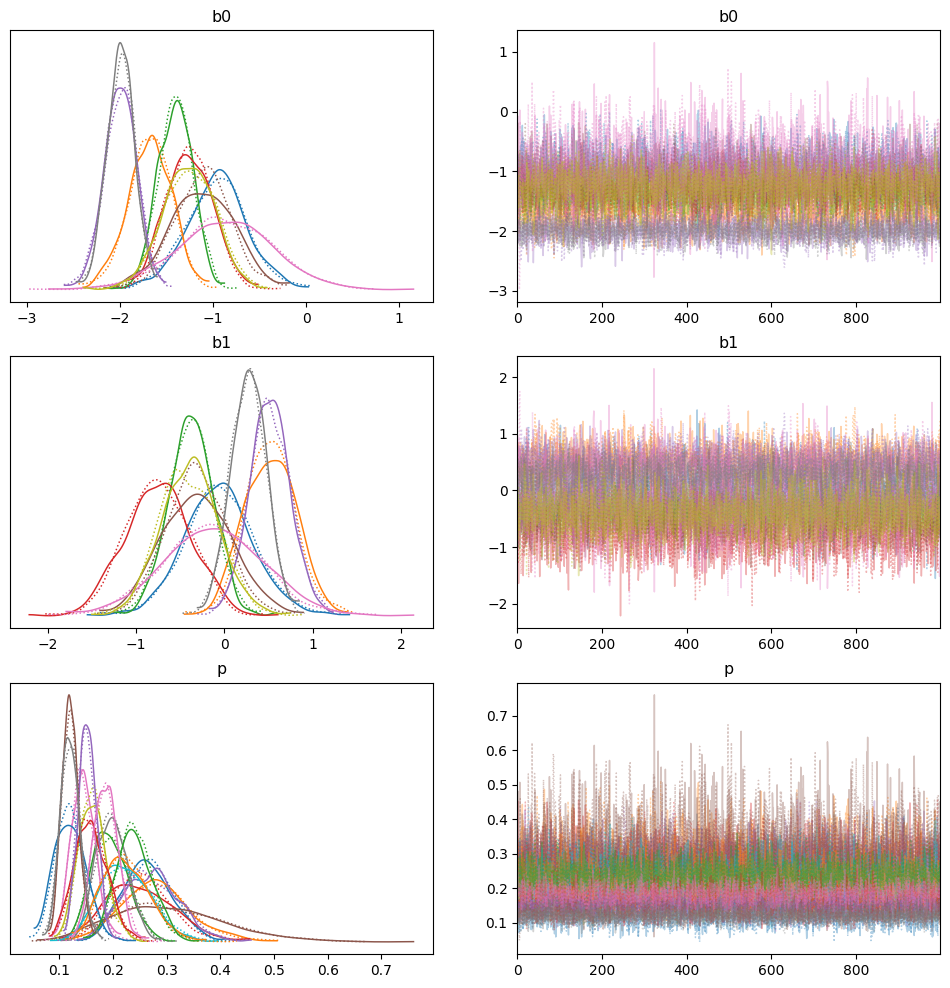

In [22]:
with control_discipline_model:
    pm.traceplot(trace_disc, figsize=(12, 12))

In [23]:
with control_discipline_model:
    ppc_disc = pm.sample_posterior_predictive(
        trace_disc, var_names=["p", "b0", "b1"], random_seed=43, samples=10_000
    )

In [24]:
men = ppc_disc["p"].T[df["gender_int"].values == 1]
women = ppc_disc["p"].T[df["gender_int"].values == 0]

In [67]:
applications_men = df.loc[df["gender_int"].values == 1, :]["applications"].T
applications_women = df.loc[df["gender_int"].values == 0, :]["applications"].T

men_avgs = (men * np.array([applications_men]).T).sum(axis=0) / np.sum(applications_men)
women_avgs = (women * np.array([applications_women]).T).sum(axis=0) / np.sum(applications_women)



In [69]:
print("ATE", (men_avgs - women_avgs).mean())

ATE 0.01809828172406941


<Axes: ylabel='Density'>

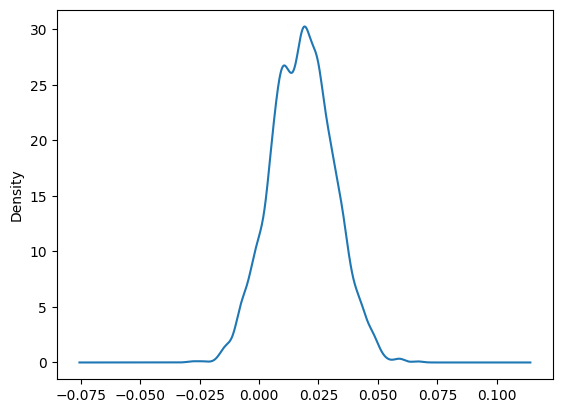

In [89]:
pd.Series(men_avgs - women_avgs).plot(
    kind="density"
)

In [84]:
# Frequentist calculation
df_pivot = df.pivot(
    index="discipline",
    columns="gender",
).assign(
    award_rate_diff=lambda x: x[("award_rate", "m")] - x[("award_rate", "f")],
    total_applications=lambda x: x[("applications", "m")] + x[("applications", "f")],
)

(df_pivot["award_rate_diff"] * df_pivot["total_applications"]).sum() / df_pivot["total_applications"].sum()

0.01603749262529814